# MLP 多层感知机

在这个任务中，您将使用numpy实现MLP，完成本任务后，您将能够：

- 熟悉MLP的前向传播与梯度后向传播过程，掌握解耦合的梯度反向传播方法
- 尝试不同的参数初始化方法
- 熟悉线性层的前向传播和后向传播实现
- 熟悉不同激活函数的优势和不足，掌握激活层的前向传播和后向传播实现
- 熟悉基于cross entropy损失函数的softmax分类层的前向传播和后向传播实现
- 建立MLP，实现在moon，iris等数据集上的分类任务

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
from sklearn.datasets import make_circles, load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score
from utils import load_moon_dataset, load_planar_dataset, plot_decision_boundary
from collections import OrderedDict
import math

%matplotlib inline 

## MLP示意图

<img src="figures/MLP.png" width = 60%>

上图展示了单隐层的MLP。当多隐层的MLP堆叠起来，它就有了深度神经网络的万能近似能力。实际上，两层的MLP就具备强大的拟合能力：在数据足够多的时候，足够宽的（神经元足够多的）两层网络可以逼近任意连续函数。

## 符号与前向传播更新公式

用$Z^{l}$表示神经网络第$l$层线性层的输出，$A^{l}$表示神经网络第$l$层激活层的输出。$w^{l}$表示神经网络第$l-1$层到第$l$层的权重矩阵，$b^{l}$表示神经网络第$l-1$层到第$l$层的偏置，$\sigma$表示激活函数。那么更新公式如下：
$$
Z^{l} = w^{l} A^{l-1} + b^{l}
$$

$$
A^{l} = \sigma(Z^{l})
$$

## 反向传播

对于较深的网络，手工推导每一层参数的梯度很繁琐也容易出错。在实际中，基于数值微分的梯度计算通常只用于梯度校验。这时就需要利用计算图，依赖链式法则来自动进行梯度反向传播，以求解各个参数的梯度。

梯度反向传播一般有以下实现方式：

- 手动实现各个模块的前向和反向计算过程（解耦合），然后把各个模块拼接起来。缺点就是反向过程也需要手动实现。本次任务主要用到此类方法。具体的公式将在每个模块单独介绍。
- 基于自动计算图的自动微分，可以直接底层实现反向传播，更简便（可以只专注于网络的搭建）。大作业将会用到这种方法。

## 参数初始化

> 为什么初始化很重要

不正确初始化的权重会导致梯度消失或爆炸问题，从而对训练过程产生负面影响。使用过小的权重进行初始化，可能导致收敛速度变慢，在最坏的情况下，可能会阻止网络完全收敛；相反，使用过大的权重进行初始化可能会导致在前向传播或反向传播过程中梯度值爆炸。

> 常见的初始化方法

- 全零或等值初始化

在线性回归、logistics回归的时候，把参数初始化为0，模型也能够很好的工作。然而，在神经网络中，把参数初始化为0或者等值是**不可以**的，因为如果等值初始化，那么每一层的神经元学到的东西都是一样的，即输出是一样的，并且在梯度回传的时候，每一层内的神经元也是相同的，因为他们的梯度相同。

- 随机初始化

比较常用的方法是随机初始化。乘weight_scale（0.01）是为了把参数随机初始化到一个相对较小的值，因为如果输入很大，参数又相对较大的话，会导致经过线性层后的$Z$非常大，如果激活函数是sigmoid，就会导致sigmoid的输出值1或者0，从而在计算损失函数的时候遇到数值问题（log里的数值是0）。

- He Initialization

该初始化方法来自Kaiming的论文《Delving deep into rectifiers: Surpassing human-level performance on ImageNet classification》，该方法对tanh，relu等激活函数更为鲁棒。

激活函数的选择在决定初始化方法的有效性方面发挥着重要作用。激活函数是可微的，并将非线性特性引入神经网络，这对于解决机器学习和深度学习旨在解决的复杂任务至关重要。ReLU和leaky ReLU是常用的激活函数，因为它们对消失/爆炸梯度问题相对鲁棒。现在神经网络中，隐藏层常使用ReLU，权重初始化常用He initialization方法。

下面的代码定义了 `init_para` 函数用于初始化神经网络的权重和偏置。函数接受四个参数：

- `input_dim`：输入特征的数量。
- `output_dim`：输出特征的数量。
- `init_method`：初始化方法的选择，默认为 "kaiming"。可以选择 "zero"、"random" 或 "kaiming"。
- `weight_scale`：当 `init_method` 为 "random" 时，权重的初始化范围为 `[0, weight_scale]`。默认为 0.01。

函数根据 `init_method` 的值来选择不同的初始化方法：

- 如果 `init_method` 为 "zero"，权重 `w` 和偏置 `b` 都被初始化为全零。
- 如果 `init_method` 为 "random"，权重 `w` 被初始化为 `[0, weight_scale]` 之间的随机数，偏置 `b` 被初始化为全零。
- 如果 `init_method` 为 "kaiming"，权重 `w` 被初始化为服从标准正态分布的随机数，然后乘以 `np.sqrt(2 / input_dim)` 进行缩放，偏置 `b` 被初始化为全零。

In [2]:
def init_para(input_dim, output_dim, init_method="kaiming", weight_scale=0.01):
    if init_method == "zero": 
        w = np.zeros((input_dim, output_dim))
        b = np.zeros((1, output_dim))
    elif init_method == "random":
        w = np.random.rand(input_dim, output_dim) * weight_scale
        b = np.zeros((1, output_dim))
    elif init_method == "kaiming":
        w = np.random.randn(input_dim, output_dim) * np.sqrt(2 / input_dim)
        b = np.zeros((1, output_dim))
    else:
        print("Unsupported initialization method!")
        exit

    assert(w.shape == (input_dim, output_dim))
    assert(b.shape == (1, output_dim))
    return w, b

## 线性层

下面的代码定义 `Linear` 的类用于代表了一个线性层。

- `__init__` 方法

参数`w` 和 `b`分别代表该线性层的权重和偏置，即$w^{l}$和$b^{l}$，并初始化一些用于反向传播的梯度变量。

- `forward` 方法

参数 `A_prev`代表上一层的激活输出，即$A^{l-1}$。计算线性层的输出 `Z`，即$Z^{l}$，其中 $Z^{l} = w^{l} · A^{l-1} + b^{l}$。

- `backward` 方法

参数 `dZ`代表线性层输出的梯度。计算权重 `w`、偏置`b` 和输入`A_prev` 的梯度，具体的，权重 `w`的梯度：
$$dw^{l} = (A^{l-1})^{T} * dZ^{l}$$
偏置 `b`的梯度
$$db^{l} = dZ^{l}(axis=0)$$
其中axis=0表示第0轴上的和，输入 `A_prev` 的梯度
$$dA^{l-1} = dZ^{l} * (w^{l})^{T}$$

In [3]:
class Linear:
    def __init__(self, w, b):
        self.w = w
        self.b = b
        self.A_prev = None
        self.dw = None
        self.db = None
        self.dA_prev = None

    def forward(self, A_prev):
        # print("Forward: A_prev.shape:", A_prev.shape)
        self.A_prev = A_prev
        Z = np.dot(self.A_prev, self.w) + self.b
        assert (Z.shape == (self.A_prev.shape[0], self.w.shape[1]))
        return Z

    def backward(self, dZ):
        m = self.A_prev.shape[0]
        # print("Backward: A_prev.shape:", self.A_prev.shape)
        self.dw = np.dot(self.A_prev.T, dZ)
        self.db = np.sum(dZ, axis=0, keepdims=True)
        self.dA_prev = np.dot(dZ, self.w.T)
        assert (self.dA_prev.shape == self.A_prev.shape)
        assert (self.dw.shape == self.w.shape)
        assert (self.db.shape == self.b.shape)
        return self.dw, self.db, self.dA_prev

## 激活层

> 激活函数公式以及梯度公式

![激活函数公式以及梯度公式](figures/activation.png)

> 不同激活函数特点
- sigmoid 函数：一般用于二分类

- ReLU 函数：当 z > 0 时，梯度始终为 1，从而提高神经网络基于梯度算法的运算速度，收敛速度远大于 sigmoid 和 tanh。然而当 z < 0 时，梯度一直为 0，但实际运用中该缺陷的影响不是很大。

- Leaky ReLU：Leaky ReLU 保证在 z < 0 的时候，梯度仍然不为 0。理论上来说，Leaky ReLU 有 ReLU 的所有优点，但在实际操作中没有证明总是好于 ReLU，因此不常用。

- tanh 函数：效果几乎总比 sigmoid 函数好（除了二元分类的输出层，因为希望输出的结果介于 0 到 1 之间），因为函数输出介于 -1 和 1 之间，激活函数的平均值就更接近 0，有类似数据中心化的效果。然而，tanh 函数存在和 sigmoid 函数一样的缺点：当 z 无穷大（或无穷小）时梯度趋近于 0，使得梯度算法的速度大大减缓。   

激活函数的选择在决定初始化方法的有效性方面发挥着重要作用。激活函数是可微的，并将非线性特性引入神经网络，这对于解决机器学习和深度学习旨在解决的复杂任务至关重要。ReLU和leaky ReLU是常用的激活函数，因为它们对消失/爆炸梯度问题相对鲁棒。现在神经网络中，隐藏层常使用ReLU，权重初始化常用He initialization方法。

下面的代码定义了几个激活函数的类。每个类都有 `forward` 和 `backward` 方法，分别用于前向传播和反向传播。其中`forward` 用于计算激活函数的输出，`backward` 用于计算激活函数输出的梯度。

这些激活函数类在神经网络的训练过程中起着关键作用，因为它们引入了非线性，使得神经网络能够学习和表示复杂的函数。

In [4]:
class Sigmoid:
    def __init__(self):
        self.A = None

    def forward(self, Z):
        A = 1 / (1 + np.exp(-Z))
        self.A = A
        return A

    def backward(self, dA):
        dZ = dA * (1 - self.A) * self.A
        return dZ

class Relu:
    def __init__(self):
        self.mask = None

    def forward(self, Z):
        self.mask = (Z <= 0)
        A = np.maximum(0, Z)
        return A

    def backward(self, dA):
        dZ = np.array(dA, copy=True)
        dZ[self.mask] = 0
        return dZ

class LeakyRelu:
    def __init__(self):
        self.mask = None

    def forward(self, Z):
        self.mask = (Z <= 0)
        A = np.maximum(0.01*Z, Z)
        return A

    def backward(self, dA):
        dZ = np.array(dA, copy=True)
        dZ[self.mask] = 0.01
        return dZ

class Tanh:
    def __init__(self):
        self.A = None

    def forward(self, Z):
        A = np.tanh(Z)
        self.A = A
        return A

    def backward(self, dA):
        dZ = dA * (1 - self.A**2)
        return dZ

## Softmax激活函数和Cross Entropy损失函数

对于多分类问题$y\in \{1,\ldots, C\}$，如果使用softmax分类器，相当于网络最后一层设置$C$个神经元，激活函数为softmax，输出为每个类的条件概率，即
$$
\hat{y} = softmax(Z^{L})
$$

下面的代码定义了`SoftmaxWithCELoss` 类，用于将 Softmax 激活函数与交叉熵损失结合在一起。

- `forward` 方法计算 Softmax 激活函数的输出，并将其存储在 `y_pred` 中。
- `backward` 方法计算损失函数关于 Softmax 输入的梯度。输入$Z$的梯度$dZ = (y_{pred}-y) / n$，感兴趣的可以尝试推导。该梯度是Softmax层的输出和真实标签的差值。神经网络的反向传播会把这个差分表示的误差传递给前面的层，这是神经网络学习中的重要性质。

In [5]:
def softmax(Z):
    exp_Z = np.exp(Z - np.max(Z, axis=-1, keepdims=True))
    A = exp_Z / np.sum(exp_Z, axis=-1, keepdims=True)
    assert(A.shape == Z.shape)
    return A

def cross_entropy_loss(y_pred, y):
    loss = -np.sum(y * np.log(y_pred + 1e-8)) / y.shape[0]
    return loss

class SoftmaxWithCELoss:
    """ Softmax Activation With Cross-Entropy Loss """
    def __init__(self):
        self.y = None
        self.y_pred = None

    def forward(self, Z):
        self.y_pred = softmax(Z)
        return self.y_pred

    def backward(self, y):
        self.y = y
        dZ = (self.y_pred - y) / y.shape[0]
        assert(dZ.shape == self.y_pred.shape)
        return dZ

## 性能评估

基于Cross Entropy Loss计算损失，并且计算准确率。

In [6]:
def evauate(y_pred, y):
    loss = cross_entropy_loss(y_pred, y)
    acc = np.mean(np.argmax(y_pred, axis=1) == np.argmax(y, axis=1))
    return loss, acc

## MLP的单层

下面的代码定义 `Single_layer` 的类用于代表了神经网络的单层。

- `__init__` 方法接受多个参数：

  - `input_dim`：输入特征的数量。
  - `output_dim`：输出特征的数量。
  - `init_method`：初始化方法的选择，默认为 "kaiming"。
  - `weight_scale`：权重的初始化范围，默认为 0.01。
  - `activate_func`：激活函数的选择，默认为 "Relu"。
  - `last_layer`：一个布尔值，表示是否为网络的最后一层，默认为 `False`。

在 `__init__` 方法中，权重 `w` 和偏置 `b` 通过 `init_para` 函数初始化，然后创建一个 `Linear` 对象。如果 `last_layer` 为 `False`，根据 `activate_func` 的值选择激活函数，并创建相应的激活函数对象。如果 `last_layer` 为 `True`，则激活函数为 `SoftmaxWithCELoss`。

- `forward` 方法

接受一个参数 `A_prev`，代表上一层的激活输出。它首先通过线性层计算输出 `Z`，然后通过激活函数计算最终的激活输出 `A`。

- `backward` 方法

接受一个参数 `dA`，代表激活输出的梯度。它首先通过激活函数的反向传播计算损失函数关于线性层输出的梯度 `dZ`，然后通过线性层的反向传播计算权重 `w`、偏置 `b` 和输入 `A_prev` 的梯度。

- `update` 方法

接受一个参数 `learning_rate`，代表学习率。它使用梯度下降法更新权重 `w` 和偏置 `b`。

In [7]:
class Single_layer():
    def __init__(self, input_dim, output_dim, init_method="kaiming", weight_scale=0.01, activate_func="Relu", optimizer="SGD", last_layer=False):
        self.w, self.b = init_para(input_dim, output_dim, init_method, weight_scale)
        self.linear = Linear(self.w, self.b)

        if not last_layer:
            if activate_func == "Relu":
                self.activation = Relu()
            elif activate_func == "LeakyRelu":
                self.activation = LeakyRelu()
            elif activate_func == "Sigmoid":
                self.activation = Sigmoid()
            elif activate_func == "Tanh":
                self.activation = Tanh()
            else:
                print("Unsupported activation function!")
                exit
        else:
            self.activation = SoftmaxWithCELoss()

        self.A_prev = None
        self.Z = None
        self.A = None
        self.dA_prev = None
        self.dZ = None
        self.dw = None
        self.db = None

        self.optimizer = optimizer
        if self.optimizer == "SGD":    
            pass
        elif self.optimizer == "Momentum":
            self.vw, self.vb = np.zeros_like(self.w), np.zeros_like(self.b)
        else:
            print("Unsupported optimizer!")
            exit

    def forward(self, A_prev):
        self.A_prev = A_prev
        self.Z = self.linear.forward(self.A_prev)
        self.A = self.activation.forward(self.Z)
        return self.A

    def backward(self, dA):
        self.dZ = self.activation.backward(dA)
        self.dw, self.db, self.dA_prev = self.linear.backward(self.dZ)

        assert (self.dA_prev.shape == self.A_prev.shape)
        assert (self.dw.shape == self.w.shape)
        assert (self.db.shape == self.b.shape)
        return self.dA_prev

    def update(self, learning_rate, momentum=0.9):
        if self.optimizer == "SGD":
            self.w -= learning_rate * self.dw
            self.b -= learning_rate * self.db
        elif self.optimizer == "Momentum":
            self.vw = momentum * self.vw + (1 - momentum) * self.dw
            self.vb = momentum * self.vb + (1 - momentum) * self.db
            self.w -= learning_rate * self.vw
            self.b -= learning_rate * self.vb

## MLP

下面的代码定义 `MLP` 的类用于代表了多层感知器（Multi-Layer Perceptron）模型。

- `__init__` 方法接受多个参数：

  - `layer_dim_list`：一个列表，包含了每一层的神经元数量。
  - `num_classes`：输出类别的数量。
  - `init_method`：初始化方法的选择，默认为 "kaiming"。
  - `weight_scale`：权重的初始化范围，默认为 0.01。
  - `activate_func`：激活函数的选择，默认为 "Relu"。

在 `__init__` 方法中，使用 `OrderedDict` 来存储每一层的 `Single_layer` 对象。最后一层是 `Single_layer` 对象，但 `last_layer` 参数被设置为 `True`，表示它是一个 Softmax 层。

- `forward` 方法

接受一个参数 `X`，代表输入数据。它依次通过每一层的 `forward` 方法计算最终的输出。

- `backward` 方法

接受一个参数 `Y`，代表真实标签。它首先通过最后一层的 `backward` 方法计算损失函数关于激活输出的梯度，然后通过每一层的 `backward` 方法计算损失函数关于权重和偏置的梯度。

- `update` 方法

接受一个参数 `learning_rate`，代表学习率。它使用梯度下降法更新每一层的权重和偏置。

- `train` 方法接受多个参数：

  - `X`：输入数据。
  - `Y`：真实标签。
  - `learning_rate`：学习率。
  - `epochs`：训练的轮数。
  - `is_plot`：一个布尔值，表示是否绘制损失曲线，默认为 `True`。

在 `train` 方法中，模型通过前向传播、反向传播和权重更新来训练。每经过一定数量的轮数（这里是每 10 轮），它会计算并打印损失和准确率。如果 `is_plot` 为 `True`，它还会绘制损失曲线。

- `predict` 方法

`predict` 方法接受一个参数 `X`，代表输入数据。它使用训练好的模型进行预测，返回预测结果。

In [8]:
def random_mini_batches(X, Y, mini_batch_size=64, seed=2024): 
    np.random.seed(seed)
    m = X.shape[0]
    
    permutation = list(np.random.permutation(m)) 
    shuffled_X, shuffled_Y = X[permutation,:], Y[permutation,:]   
    
    num_minibatches = math.floor(m / mini_batch_size) + 1
    minibatch_X = np.array_split(shuffled_X, num_minibatches)
    minibatch_Y = np.array_split(shuffled_Y, num_minibatches)

    mini_batches = list(zip(minibatch_X, minibatch_Y))      
    return mini_batches

In [9]:
class MLP():
    def __init__(self, layer_dim_list, num_classes, init_method="kaiming", weight_scale=0.01, activate_func="Relu", optimizer="Momentum"):
        self.layers = OrderedDict()

        for i in range(len(layer_dim_list) - 1):
            input_dim = layer_dim_list[i]
            output_dim = layer_dim_list[i-1]
            self.layers['layer' + str(i)] = Single_layer(input_dim, output_dim, init_method, weight_scale, activate_func, optimizer)

        self.lastlayer = Single_layer(layer_dim_list[-1], num_classes, init_method, weight_scale, last_layer=True)

    def forward(self, X):
        A = X
        for layer in self.layers.values():
            A = layer.forward(A)
        A = self.lastlayer.forward(A)
        return A

    def backward(self, Y):
        dA_prev = self.lastlayer.backward(Y)
        for layer in reversed(self.layers.values()):
            dA_prev = layer.backward(dA_prev)

    def update(self, learning_rate):
        for layer in self.layers.values():
            layer.update(learning_rate)
        self.lastlayer.update(learning_rate)

    def train(self, X, Y, learning_rate, epochs, mini_batch_size=128, is_plot=True):
        minibatches = random_mini_batches(X, Y, mini_batch_size)
        
        losses = []
        accs = []
        for i in range(epochs):
            loss_avg, acc_avg = 0, 0
            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                minibatch_Y_pred = self.forward(minibatch_X)
                self.backward(minibatch_Y)
                self.update(learning_rate)
                loss, acc = evauate(minibatch_Y_pred, minibatch_Y)
                loss_avg += loss
                acc_avg += acc

            if i % 10 == 0:
                losses.append(loss_avg / len(minibatches))
                accs.append(acc_avg / len(minibatches))
                print("Epoch: %d, Loss: %.3f, Acc: %.3f" % (i, loss_avg/len(minibatches), acc_avg/len(minibatches)))

        if is_plot:
            plt.figure(figsize=(6,4))
            plt.plot(losses)
            plt.ylabel('Loss Curve')
            plt.xlabel('Iterations (per 10)')
            plt.title("Learning rate =" + str(learning_rate))
            plt.show()

        print("Accuracy of Training Dataset:", format(accs[-1] * 100), "%")

    def predict(self, X):
        y_pred = self.forward(X)
        return y_pred

## 加载数据集

以下是三个人造数据集，可视化如下：

- MOON 数据集
  
<img src="figures/moon.png" width = 40%>

- CIRCLE 数据集

<img src="figures/circle.png" width = 40%>

- PLANAR 数据集

<img src="figures/planar.png" width = 40%>

由此看见三个数据集都不是线性可分的，因此需要用MLP来拟合。

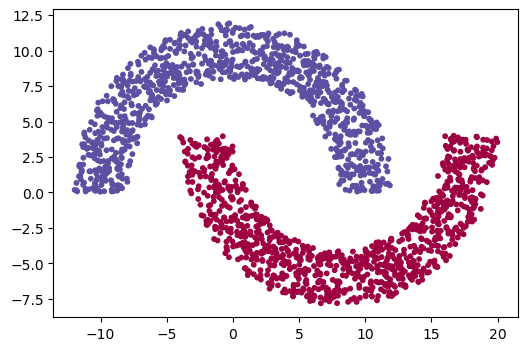

In [10]:
def load_dataset(dataset_name):
    if dataset_name == "circle":
        # load circle dataset
        x_train, y_train = make_circles(n_samples=1000, noise=0.06, factor=0.5)
        train_dataset = np.concatenate([x_train, y_train.reshape(-1,1)], axis=1)
        x_test, y_test = make_circles(n_samples=2000, noise=0.06, factor=0.5)
        test_dataset = np.concatenate([x_test, y_test.reshape(-1,1)], axis=1)
    elif dataset_name == "moon":
        # load moon dataset
        train_dataset = load_moon_dataset(N=1000, d=-4)
        test_dataset = load_moon_dataset(N=2000, d=-4)
    elif dataset_name == "planar":
        # load planar dataset
        train_dataset = load_planar_dataset(N=1000)
        test_dataset = load_planar_dataset(N=2000)
    else:
        exit

    return train_dataset, test_dataset 

dataset_name = "moon"
assert dataset_name in ["circle", "moon", "planar"]
train_dataset, test_dataset = load_dataset(dataset_name)

plt.figure(figsize=(6,4))
plt.scatter(train_dataset[:,0], train_dataset[:,1], c=train_dataset[:,-1], s=10, cmap=plt.cm.Spectral)

## 模型训练

首先对真实标签进行one-hot编码，这里我们使用单隐层MLP，设置`layer_dim_list`为[X的维度，隐藏层神经元=20]，即`layer_dim_list`为[X.shape[1], 20]。训练轮数2000论，学习率简单的设置为0.1。

输出每10轮的训练损失和训练集上的准确率，画出学习曲线以及最终的决策边界。

Epoch: 0, Loss: 1.512, Acc: 0.829
Epoch: 10, Loss: 0.213, Acc: 0.909
Epoch: 20, Loss: 0.140, Acc: 0.931
Epoch: 30, Loss: 0.112, Acc: 0.951
Epoch: 40, Loss: 0.092, Acc: 0.959
Epoch: 50, Loss: 0.075, Acc: 0.963
Epoch: 60, Loss: 0.060, Acc: 0.975
Epoch: 70, Loss: 0.047, Acc: 0.987
Epoch: 80, Loss: 0.037, Acc: 0.994
Epoch: 90, Loss: 0.029, Acc: 0.998
Epoch: 100, Loss: 0.024, Acc: 1.000
Epoch: 110, Loss: 0.019, Acc: 1.000
Epoch: 120, Loss: 0.016, Acc: 1.000
Epoch: 130, Loss: 0.014, Acc: 1.000
Epoch: 140, Loss: 0.012, Acc: 1.000
Epoch: 150, Loss: 0.011, Acc: 1.000
Epoch: 160, Loss: 0.009, Acc: 1.000
Epoch: 170, Loss: 0.008, Acc: 1.000
Epoch: 180, Loss: 0.008, Acc: 1.000
Epoch: 190, Loss: 0.007, Acc: 1.000
Epoch: 200, Loss: 0.006, Acc: 1.000
Epoch: 210, Loss: 0.006, Acc: 1.000
Epoch: 220, Loss: 0.006, Acc: 1.000
Epoch: 230, Loss: 0.005, Acc: 1.000
Epoch: 240, Loss: 0.005, Acc: 1.000
Epoch: 250, Loss: 0.005, Acc: 1.000
Epoch: 260, Loss: 0.004, Acc: 1.000
Epoch: 270, Loss: 0.004, Acc: 1.000
Epo

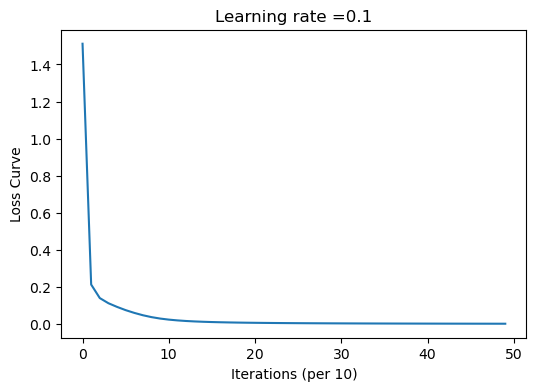

Accuracy of Training Dataset: 100.0 %


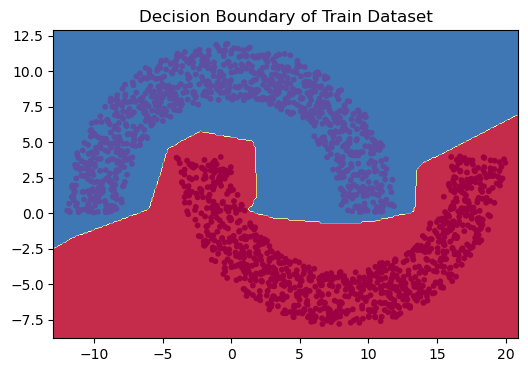

In [11]:
x_train = train_dataset[:,:-1]
y_train = train_dataset[:,-1]

encoder = OneHotEncoder(sparse_output=False)
y_train_encoder = encoder.fit_transform(y_train.reshape(-1, 1))

layer_dim_list = [x_train.shape[1], 20]
network = MLP(layer_dim_list=layer_dim_list, num_classes=len(np.unique(y_train)))
network.train(x_train, y_train_encoder, epochs=500, learning_rate=0.1)
plot_decision_boundary(lambda x: np.argmax(network.predict(x), axis=1), x_train, y_train, dataset='Train')

## 模型测试

同样对真实标签进行one-hot编码，对测试集进行预测并评估损失和准确率，同样画出决策边界。

可以看到，单隐层MLP已经能很好的拟合线性不可分的MOON和CIRCLE数据集，尽管PLANAR数据集带有噪声，MLP的拟合效果还是令人满意的。

Accuracy of Test Dataset: 100.0 %


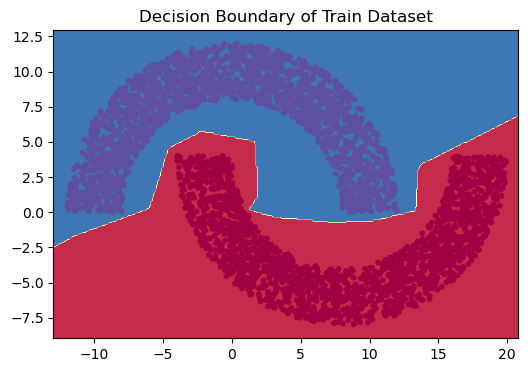

In [12]:
x_test = test_dataset[:,:-1]
y_test = test_dataset[:,-1]

encoder = OneHotEncoder(sparse_output=False)
y_test_encoder = encoder.fit_transform(y_test.reshape(-1, 1))

y_test_pred = network.predict(x_test)
loss, acc = evauate(y_test_pred, y_test_encoder)
print("Accuracy of Test Dataset:", format(acc * 100), "%")
plot_decision_boundary(lambda x: np.argmax(network.predict(x), axis=1), x_test, y_test, dataset='Train')

## Iris数据集

下面我们对iris数据集进行模型训练和预测。该数据集每个样本有四个特征，分别是花萼长度、花萼宽度、花瓣长度、花瓣宽度，总共包含3个类别，分别是山鸢尾、变色鸢尾、维吉尼亚鸢尾。因此在这部分我们忽略决策边界。

最终训练和测试的准确率都是令人满意的。

In [13]:
# load iris dataset
iris = load_iris()
x_train, x_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.2, random_state=2024)

Epoch: 0, Loss: 5.852, Acc: 0.592
Epoch: 10, Loss: 1.094, Acc: 0.650
Epoch: 20, Loss: 0.397, Acc: 0.858
Epoch: 30, Loss: 0.333, Acc: 0.967
Epoch: 40, Loss: 0.275, Acc: 0.967
Epoch: 50, Loss: 0.217, Acc: 0.975
Epoch: 60, Loss: 0.184, Acc: 0.975
Epoch: 70, Loss: 0.163, Acc: 0.983
Epoch: 80, Loss: 0.147, Acc: 0.983
Epoch: 90, Loss: 0.134, Acc: 0.983
Epoch: 100, Loss: 0.124, Acc: 0.983
Epoch: 110, Loss: 0.116, Acc: 0.983
Epoch: 120, Loss: 0.109, Acc: 0.983
Epoch: 130, Loss: 0.103, Acc: 0.983
Epoch: 140, Loss: 0.098, Acc: 0.983
Epoch: 150, Loss: 0.093, Acc: 0.983
Epoch: 160, Loss: 0.089, Acc: 0.983
Epoch: 170, Loss: 0.086, Acc: 0.983
Epoch: 180, Loss: 0.083, Acc: 0.983
Epoch: 190, Loss: 0.080, Acc: 0.983
Epoch: 200, Loss: 0.077, Acc: 0.983
Epoch: 210, Loss: 0.075, Acc: 0.983
Epoch: 220, Loss: 0.073, Acc: 0.983
Epoch: 230, Loss: 0.071, Acc: 0.983
Epoch: 240, Loss: 0.069, Acc: 0.983
Epoch: 250, Loss: 0.068, Acc: 0.983
Epoch: 260, Loss: 0.066, Acc: 0.983
Epoch: 270, Loss: 0.065, Acc: 0.983
Epo

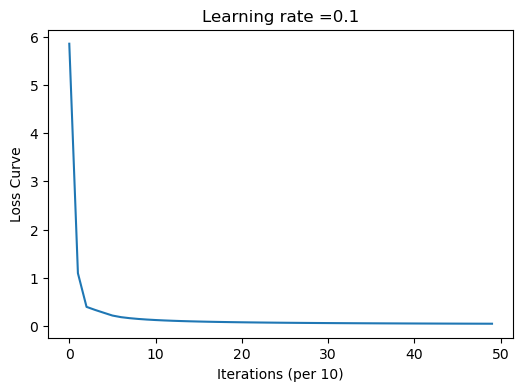

Accuracy of Training Dataset: 99.16666666666667 %


In [14]:
encoder = OneHotEncoder(sparse_output=False)
y_train_encoder = encoder.fit_transform(y_train.reshape(-1, 1))

layer_dim_list = [x_train.shape[1], 30]
network = MLP(layer_dim_list=layer_dim_list, num_classes=len(np.unique(y_train)))
network.train(x_train, y_train_encoder, epochs=500, learning_rate=0.1)

In [15]:
y_test_encoder = encoder.fit_transform(y_test.reshape(-1, 1))

y_test_pred = network.predict(x_test)
loss, acc = evauate(y_test_pred, y_test_encoder)
print("Accuracy of Test Dataset:", format(acc * 100), "%")

Accuracy of Test Dataset: 93.33333333333333 %


你已经成功完成了本次实验！值得注意的是，训练深度神经网络有很多值得注意的技巧，包括初始化网络参数、对激活值进行归一化、正则化、学习率调节、选择合适的优化算法以及设计更好的网络结构（残差连接）等。

## 课后任务包括
必做
- 将实验里使用的全局梯度下降修改为 mini-batch 随机梯度下降；
- 使用sklearn加载MNIST数据集，测试MLP在MNIST上的分类效果；
- 在随机梯度下降算法中加入动量，对比有无动量时MLP在MNIST上的收敛速度、分类效果；
- 尝试不同的隐藏层神经元数量，想要在MNIST上达到较好的效果需要多少个隐藏层神经元？
- 尝试不同的超参数组合，尽可能找到效果最好的学习率、动量系数。

选做
- 尝试不同的参数初始化方法。全零初始化可行吗？随机初始化和He初始化的模型训练相比有什么区别？训练过程稳定吗？
- 使用不同的激活函数，与Relu相比后续模型训练有什么区别？
- 尝试更深的MLP，越深的神经网络一定越好吗？

课后发送邮件，标题“神经网络实验二 + 姓名 + 学号”, 附件包括代码和实验报告，发送给 dings@smail.nju.edu.cn

## MNIST数据集

In [16]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, Y = mnist['data']/255.0, mnist['target'].astype(int)
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=2024)

/Users/apple/miniconda3/lib/python3.11/site-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


Epoch: 0, Loss: 0.551, Acc: 0.842
Epoch: 10, Loss: 0.126, Acc: 0.964
Epoch: 20, Loss: 0.085, Acc: 0.976
Epoch: 30, Loss: 0.066, Acc: 0.981
Epoch: 40, Loss: 0.054, Acc: 0.985
Epoch: 50, Loss: 0.045, Acc: 0.988
Epoch: 60, Loss: 0.038, Acc: 0.990
Epoch: 70, Loss: 0.033, Acc: 0.992
Epoch: 80, Loss: 0.028, Acc: 0.994
Epoch: 90, Loss: 0.025, Acc: 0.995
Epoch: 100, Loss: 0.022, Acc: 0.996
Epoch: 110, Loss: 0.019, Acc: 0.997
Epoch: 120, Loss: 0.017, Acc: 0.998
Epoch: 130, Loss: 0.015, Acc: 0.998
Epoch: 140, Loss: 0.013, Acc: 0.999
Epoch: 150, Loss: 0.012, Acc: 0.999
Epoch: 160, Loss: 0.010, Acc: 0.999
Epoch: 170, Loss: 0.009, Acc: 0.999
Epoch: 180, Loss: 0.008, Acc: 0.999
Epoch: 190, Loss: 0.007, Acc: 1.000


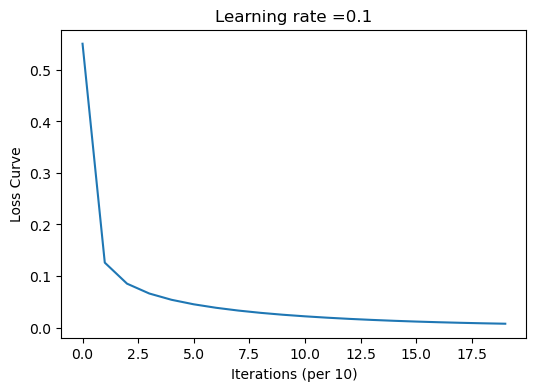

Accuracy of Training Dataset: 99.96425626056161 %


In [17]:
encoder = OneHotEncoder(sparse_output=False)
y_train_encoder = encoder.fit_transform(y_train.reshape(-1, 1))

layer_dim_list = [x_train.shape[1], 30]
network = MLP(layer_dim_list=layer_dim_list, num_classes=len(np.unique(y_train)))
network.train(x_train, y_train_encoder, epochs=200, learning_rate=0.1)

In [18]:
y_test_encoder = encoder.fit_transform(y_test.reshape(-1, 1))

y_test_pred = network.predict(x_test)
loss, acc = evauate(y_test_pred, y_test_encoder)
print("Accuracy of Test Dataset:", format(acc * 100), "%")

Accuracy of Test Dataset: 95.91428571428573 %
